# Tabular Playground Series Jan 2022

In [89]:
# Installing the modules

!pip3 install phik
!pip3 install optuna
!pip3 install kaggle

     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 44.7 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 112 kB 38.9 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 149 kB 49.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=613f5eb0c07808512d3596946374fd7996bdd08d6e87a729bf82c7a14efd4a23
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [1]:
# Required modules

import phik
import optuna
import numpy as np
import pandas as pd
import seaborn as sns

from zipfile import ZipFile
from google.colab import files
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
# Config

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [4]:
# Upload the creds

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anurag1817","key":"09b66f16e6edda0614443b2a02389465"}'}

In [5]:
# Create kaggle folder

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Test the command

!kaggle competitions download -c tabular-playground-series-jan-2022

  0% 0.00/64.2k [00:00<?, ?B/s]
100% 64.2k/64.2k [00:00<00:00, 24.7MB/s]
  0% 0.00/306k [00:00<?, ?B/s]
100% 306k/306k [00:00<00:00, 90.2MB/s]
  0% 0.00/186k [00:00<?, ?B/s]
100% 186k/186k [00:00<00:00, 56.0MB/s]


In [3]:
# Extract the zip file

with ZipFile('/content/train.csv.zip', 'r') as zf:
    zf.extractall('./')

In [4]:
# Load the data

train = pd.read_csv('train.csv', index_col='row_id', parse_dates=['date'])
train.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [5]:
# Inspecting the data

train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.2+ MB


,num_sold
count,26298.000000
mean,387.533577
std,266.076193
min,70.000000
25%,190.000000
50%,315.000000
75%,510.000000
max,2884.000000


interval columns not set, guessing: ['num_sold']


/usr/local/lib/python3.7/dist-packages/phik/data_quality.py:62: UserWarning:

The number of unique values of variable date is large: 1461. Are you sure this is not an interval variable? Analysis for pairs of variables including date can be slow.



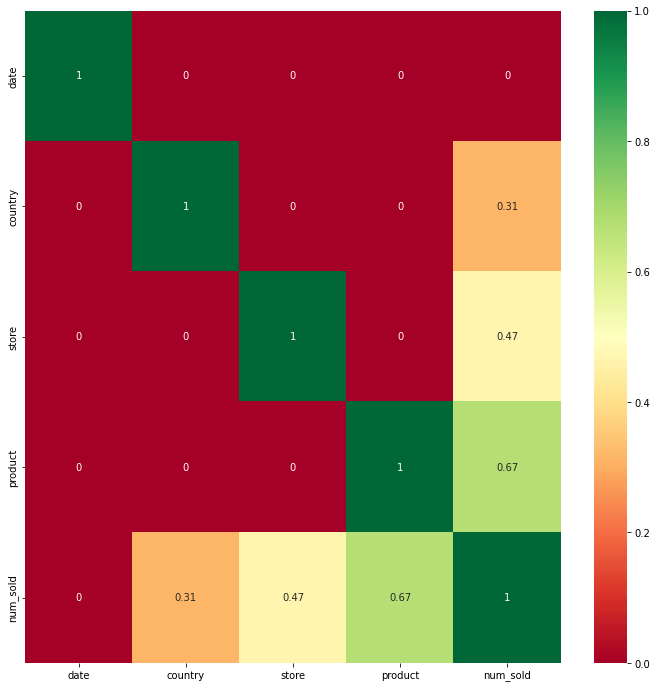

In [6]:
# Correlation matrix

sns.heatmap(phik.phik_matrix(train), annot=True, cmap='RdYlGn')

In [7]:
# Load the test data

test = pd.read_csv('test.csv', index_col='row_id', parse_dates=['date'])
test.head()

,date,country,store,product
row_id,,,,
26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


There are no missing values, in the data.

In [8]:
# Missing values

if train.isna().any().any():
    print(train.isna().sum()/train.shape[0])
else:
    print("No Missing values")

No Missing values


## Preprocessing

In [9]:
# Custom Classes

class LabelEncoderExt(TransformerMixin, BaseEstimator):
    def __init__(self, classes=None):
        self.classes = classes

    def fit(self, y):
        if self.classes is None:
            self.classes = np.unique(y)

        self.encoding = {k: v for v, k in enumerate(self.classes, start=0)}

    def transform(self, y):
        if isinstance(y, pd.core.series.Series):
            return y.map(self.encoding)
        else:
            return np.array([self.encoding[v] for v in y])

    def fit_transform(self, y):
        self.fit(y)

        return self.transform(y)

In [10]:
# Categorical columns

cat_cols = [col for col in train.columns if train[col].dtype == 'object']

In [11]:
# Expanding the feature spaces

## datetime
train['datenum'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['weekday'] = train['date'].dt.weekday

test['datenum'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year
test['weekday'] = test['date'].dt.weekday

## categorcial feature encoding
for col in cat_cols:
    encoder = LabelEncoderExt()

    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])

In [12]:
# Seperating out features and labels

X = train.drop(['num_sold', 'date'], axis=1)
y = train['num_sold']

In [13]:
# Train Test Split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=88)

## RF

In [14]:
# Objective functions

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 2000, step=100)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    max_depth = trial.suggest_int('max_depth', 2, 5, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, n_jobs=-1)
    model.fit(X_train, y_train)

    return smape(y_valid, model.predict(X_valid))

In [16]:
# Model Definition

study = optuna.create_study(direction='minimize', study_name='Random Forest')
study.optimize(objective, n_trials=1000)

[I 2022-01-02 06:07:10,018] A new study created in memory with name: Random Forest
[I 2022-01-02 06:07:33,747] Trial 0 finished with value: 18.555828834427846 and parameters: {'n_estimators': 1900, 'max_features': None, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 0 with value: 18.555828834427846.
[I 2022-01-02 06:07:51,943] Trial 1 finished with value: 18.315755234261122 and parameters: {'n_estimators': 2000, 'max_features': None, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 1 with value: 18.315755234261122.
[I 2022-01-02 06:07:57,013] Trial 2 finished with value: 31.98776719701446 and parameters: {'n_estimators': 1100, 'max_features': 'log2', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 1 with value: 18.315755234261122.
[I 2022-01-02 06:07:57,877] Trial 3 finished with value: 22.69674996926511 and parameters: {'n_estimators': 10

In [17]:
# Fitting the best model

best_model = RandomForestRegressor(**study.best_params)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=5,
                      min_samples_split=6)

In [18]:
# Model Prediction

test_pred = best_model.predict(test.drop(['date'], axis=1))
test_pred

array([193.21904657, 385.57611226,  96.29502677, ..., 410.50329686,
       644.74254042, 209.07487192])

In [19]:
# Generating output file

submission = pd.read_csv('/content/sample_submission.csv')
submission['num_sold'] = test_pred
submission.to_csv('output.csv', index=False)

In [20]:
# Submission

!kaggle competitions submit -c tabular-playground-series-jan-2022 -f output.csv -m "RF Optuna 1000 trails"

100% 156k/156k [00:00<00:00, 730kB/s]
Successfully submitted to Tabular Playground Series - Jan 2022